In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

import os
import json

from torch.utils.data import DataLoader, Dataset
from PIL import Image

from torchinfo import summary
import torch.optim as optim
from tqdm.notebook import tqdm
from tensorboardX import SummaryWriter

import glob
import random
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Training settings
batch_size = 4
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42
image_size = (3,256,256)
sequence_length = 16

# DATASET

16 sequence image를 1개의 input으로 생각 > 16개의 이미지에 대해 1개의 label이 나오도록 함

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [5]:
# os.makedirs('data', exist_ok=True)

In [6]:
# train_dir = 'data/train'
# test_dir = 'data/test'

In [7]:
# train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
# test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [8]:
with open(r'C:\Users\CHOISJ-DT01\Desktop\train_list.txt', 'r') as f:
    data = f.read()
file_list = data.splitlines()

In [9]:
with open(r'C:\Users\CHOISJ-DT01\Desktop\annotation_list.txt', 'r') as f:
    data = f.read()
annotation = data.splitlines()

In [10]:
annotation_dict = {}
for i,class_name in enumerate(annotation):
    
    annotation_dict.setdefault(class_name,i)
    

In [11]:
del annotation_dict['HandstandPushups']

In [12]:
print(annotation_dict)

{'ApplyEyeMakeup': 0, 'ApplyLipstick': 1, 'Archery': 2, 'BabyCrawling': 3, 'BalanceBeam': 4, 'BandMarching': 5, 'BaseballPitch': 6, 'Basketball': 7, 'BasketballDunk': 8, 'BenchPress': 9, 'Biking': 10, 'Billiards': 11, 'BlowDryHair': 12, 'BlowingCandles': 13, 'BodyWeightSquats': 14, 'Bowling': 15, 'BoxingPunchingBag': 16, 'BoxingSpeedBag': 17, 'BreastStroke': 18, 'BrushingTeeth': 19, 'CleanAndJerk': 20, 'CliffDiving': 21, 'CricketBowling': 22, 'CricketShot': 23, 'CuttingInKitchen': 24, 'Diving': 25, 'Drumming': 26, 'Fencing': 27, 'FieldHockeyPenalty': 28, 'FloorGymnastics': 29, 'FrisbeeCatch': 30, 'FrontCrawl': 31, 'GolfSwing': 32, 'Haircut': 33, 'Hammering': 34, 'HammerThrow': 35, 'HandstandWalking': 37, 'HeadMassage': 38, 'HighJump': 39, 'HorseRace': 40, 'HorseRiding': 41, 'HulaHoop': 42, 'IceDancing': 43, 'JavelinThrow': 44, 'JugglingBalls': 45, 'JumpingJack': 46, 'JumpRope': 47, 'Kayaking': 48, 'Knitting': 49, 'LongJump': 50, 'Lunges': 51, 'MilitaryParade': 52, 'Mixing': 53, 'Moppin

In [13]:
annotation_dict.setdefault('HandStandPushups',36)

36

In [14]:
print(annotation_dict)

{'ApplyEyeMakeup': 0, 'ApplyLipstick': 1, 'Archery': 2, 'BabyCrawling': 3, 'BalanceBeam': 4, 'BandMarching': 5, 'BaseballPitch': 6, 'Basketball': 7, 'BasketballDunk': 8, 'BenchPress': 9, 'Biking': 10, 'Billiards': 11, 'BlowDryHair': 12, 'BlowingCandles': 13, 'BodyWeightSquats': 14, 'Bowling': 15, 'BoxingPunchingBag': 16, 'BoxingSpeedBag': 17, 'BreastStroke': 18, 'BrushingTeeth': 19, 'CleanAndJerk': 20, 'CliffDiving': 21, 'CricketBowling': 22, 'CricketShot': 23, 'CuttingInKitchen': 24, 'Diving': 25, 'Drumming': 26, 'Fencing': 27, 'FieldHockeyPenalty': 28, 'FloorGymnastics': 29, 'FrisbeeCatch': 30, 'FrontCrawl': 31, 'GolfSwing': 32, 'Haircut': 33, 'Hammering': 34, 'HammerThrow': 35, 'HandstandWalking': 37, 'HeadMassage': 38, 'HighJump': 39, 'HorseRace': 40, 'HorseRiding': 41, 'HulaHoop': 42, 'IceDancing': 43, 'JavelinThrow': 44, 'JugglingBalls': 45, 'JumpingJack': 46, 'JumpRope': 47, 'Kayaking': 48, 'Knitting': 49, 'LongJump': 50, 'Lunges': 51, 'MilitaryParade': 52, 'Mixing': 53, 'Moppin

In [15]:
print(file_list[0])

C:\Users\CHOISJ-DT01\Desktop\git\cnn-lstm\data\image_data\ApplyEyeMakeup\v_ApplyEyeMakeup_g01_c01\image_00001.jpg


In [16]:
print(file_list[0].split('\\')[-2][2:-8])

ApplyEyeMakeup


In [17]:
# print(f"Train Data: {len(train_list)}")
# print(f"Test Data: {len(test_list)}")

In [18]:
print(len(file_list))
labels = [path.split('\\')[-2][2:-8] for path in file_list]
print(len(labels))

122504
122504


In [19]:
# labels = [path.split('/')[-1].split('.')[0] for path in train_list]

In [20]:
# random_idx = np.random.randint(1, len(train_list), size=9)
# fig, axes = plt.subplots(3, 3, figsize=(16, 12))

# for idx, ax in enumerate(axes.ravel()):
#     img = Image.open(train_list[idx])
#     ax.set_title(labels[idx])
#     ax.imshow(img)


In [21]:
train_list, valid_list = train_test_split(file_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [22]:
print(train_list[0])

C:\Users\CHOISJ-DT01\Desktop\git\cnn-lstm\data\image_data\IceDancing\v_IceDancing_g25_c05\image_00113.jpg


In [23]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")

Train Data: 98003
Validation Data: 24501


In [24]:
from torchvision import datasets, transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


In [25]:
class SeqDataset(Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        
        x_seq=torch.empty((sequence_length,3,224,224))
        y = torch.empty((1))
        
        img_path = self.file_list[idx]
        
        y = annotation_dict[img_path.split('\\')[-2][2:-8]]
        
        file_num = int(img_path[-9:-4])
        for i in range(sequence_length):
            sequence_num = file_num+i
            sequence_num = str(sequence_num).zfill(5)
            img_path = img_path[:-9]+sequence_num+".jpg"
            img = Image.open(img_path)
            img_transformed = self.transform(img)
            x_seq[i] = img_transformed
            
#         y = 
#             if i == sequence_length+idx-1:
#                 y = img_path.split("/")[-1].split(".")[0]
#                 y = y.split("\\")[1]
#                 y = 1 if y == "dog" else 0
                
        
        
#         x_seq = torch.Tensor(x_seq)
#         x_seq =torch.stack(x_seq,dim=1)
#         y_seq = torch.Tensor(x_seq)
#         y_seq = torch.stack(y_seq,dim=1)
        return x_seq,y


In [26]:
# import copy

# class SeqDataset(Dataset):
#     def __init__(self,file_list,transform=None):
#         self.file_list = file_list
#         self.transform = transform
#         self.trunc_list = copy.deepcopy(file_list)
        
#         for i in range(sequence_length):
#             self.trunc_list.append(file_list[-1])
        
#     def __len__(self):
#         self.filelength = len(self.file_list)
#         return self.filelength
    
#     def __getitem__(self,idx):
        
#         x_seq=torch.empty((sequence_length,3,224,224))
#         y = torch.empty((1))
        
#         for i in range(idx,sequence_length+idx):
            
#             img_path = self.trunc_list[i]
#             img = Image.open(img_path)
#             img_transformed = self.transform(img)
#             x_seq[i-idx] = img_transformed
            
#             if i == sequence_length+idx-1:
#                 y = img_path.split("/")[-1].split(".")[0]
#                 y = y.split("\\")[1]
#                 y = 1 if y == "dog" else 0
                
        
        
# #         x_seq = torch.Tensor(x_seq)
# #         x_seq =torch.stack(x_seq,dim=1)
# #         y_seq = torch.Tensor(x_seq)
# #         y_seq = torch.stack(y_seq,dim=1)
        
#         return x_seq,y


In [27]:
train_data = SeqDataset(train_list, transform=train_transforms)
valid_data = SeqDataset(valid_list, transform=val_transforms)

In [28]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=False )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False)

In [29]:
for i, (x,y) in enumerate(train_loader):
    print("==Batch, Sequence, Channel, Height, Width==")
    print(x.shape)
    print(y)
    print(y.shape)
    break

==Batch, Sequence, Channel, Height, Width==
torch.Size([4, 16, 3, 224, 224])
tensor([43, 72, 29, 85])
torch.Size([4])


In [30]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.conv = nn.Sequential(
            #3 224 128
            nn.Conv2d(3, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #64 112 64
            nn.Conv2d(64, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #128 56 32
            nn.Conv2d(128, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #256 28 16
            nn.Conv2d(256, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #512 14 8
        )
        self.avg_pool = nn.AvgPool2d(14)
        #512 1 1
        self.classifier = nn.Linear(512, 101)

    def forward(self, x):
        features = self.conv(x)
        x = self.avg_pool(features)
#         x = torch.squeeze(x)
        
        #print(avg_pool.size())
#         x = x.view(features.size(0), -1)
        #print(flatten.size())
#         x = self.classifier(x)
        #x = self.softmax(x)
    
        return x
    

In [31]:
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

class CNNLSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,layer_dim,output_dim):
        super().__init__()
        
        ## embedding with cnn
#         self.cnn = models.vgg16(pretrained=True)
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.cnn = VGG19()
        
        self.input_dim = input_dim
        
        self.lstm = nn.LSTM(input_dim,hidden_dim,layer_dim,batch_first=True)
#         self.cnn = EfficientNet.from_pretrained('efficientnet-b0')
        
        self.fc = nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,x):
        # num_layers*bidirectional, batch_size, n_hidden)
        hidden = torch.zeros(self.layer_dim, batch_size, self.hidden_dim, requires_grad=True).to(device)
        cell = torch.zeros(self.layer_dim, batch_size, self.hidden_dim, requires_grad=True).to(device)
        
        batchsize, time_steps,C,H,W = x.size()
        c_in = x.view(batchsize * time_steps,C,H,W)
#         # 후에 no grad
#         with torch.no_grad():
#             c_out = self.cnn(c_in)
        c_out = self.cnn(c_in)
        
        r_in = c_out.view(batchsize, time_steps, -1)
        # r_in = [Batch, sequence length, input dimension(512)]
        r_out,(hn,cn) = self.lstm(r_in,(hidden,cell))
        
        # r_out = [batch, sequeence, 128]
        
        x = self.fc(r_out[:,-1,:])
        
        return torch.sigmoid(x)

In [32]:
input_dim = 512
hidden_dim = 128
layer_dim = 1
output_dim = 101

In [33]:
model = CNNLSTM(input_dim,hidden_dim,layer_dim,output_dim).to(device)

In [34]:
summary(model,(batch_size,sequence_length,3,224,224))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM                                  --                        --
├─VGG19: 1-1                             [64, 512, 1, 1]           --
│    └─Sequential: 2-1                   [64, 512, 14, 14]         --
│    │    └─Conv2d: 3-1                  [64, 64, 224, 224]        1,792
│    │    └─LeakyReLU: 3-2               [64, 64, 224, 224]        --
│    │    └─Conv2d: 3-3                  [64, 64, 224, 224]        36,928
│    │    └─LeakyReLU: 3-4               [64, 64, 224, 224]        --
│    │    └─MaxPool2d: 3-5               [64, 64, 112, 112]        --
│    │    └─Conv2d: 3-6                  [64, 128, 112, 112]       73,856
│    │    └─LeakyReLU: 3-7               [64, 128, 112, 112]       --
│    │    └─Conv2d: 3-8                  [64, 128, 112, 112]       147,584
│    │    └─LeakyReLU: 3-9               [64, 128, 112, 112]       --
│    │    └─MaxPool2d: 3-10              [64, 128, 56, 56]         --

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.00001)

In [36]:
writer= SummaryWriter('runs/cnn-lstm')

# Show Image

In [37]:
import matplotlib.pyplot as plt


image,label = next(iter(train_loader))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([16, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


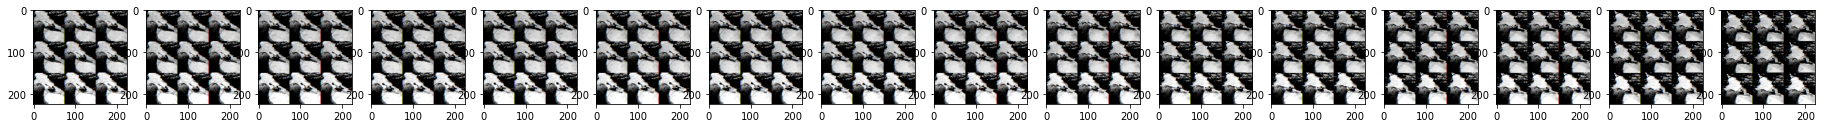

In [38]:
import matplotlib.pyplot as plt
import os
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK']='True'

rows = 1
cols = 20
axes = []
fig=plt.figure(figsize=(40,40))

image,label = next(iter(valid_loader))

print(image[0].shape)

for i in range(sequence_length):
    axes.append(fig.add_subplot(rows,cols,i+1))
    img = image[0][i].view(224,224,3)
    plt.imshow(img)
# print(image.shape)
# print(image[0][1].shape)
# plt.imshow(image[0][9].reshape(224,224,3))

# plt.imshow(image[0].numpy()[0].reshape(224,224,3))

# for i in range(10):
#     axes.append( fig.add_subplot(rows,cols,i+1))
#     img = image[i].view(224,224,3)
#     plt.imshow(img)


In [ ]:
for epoch in range(10):
    epoch_loss = 0
    epoch_acc = 0
    
    for data,label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
                         
        output = model(data)
        
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_loss += loss / len(train_loader)
        epoch_acc += acc /len(train_loader)
        
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device, dtype=torch.long)

            val_output = model(data)
            
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
        writer.add_scalar('validation_loss',epoch_val_loss,epoch)

    writer.add_scalar('training_loss',epoch_loss,epoch)


    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_acc:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
        
        

  0%|          | 0/24501 [00:00<?, ?it/s]